In [1]:
import os
import shutil
import numpy as np
import nibabel as nib
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

## Initial parameters

In [2]:
labels = [4.0, 43.0]

input_dir = 'NKI-RS-22-20'
input_mask_niftii = 'aseg-in-t1weighted_2std.nii.gz'
input_img_niftii = 't1weighted_2std.nii.gz'

## Load image data from NIFTII

In [3]:
def load_image_data(filename, dirname=''):
    full_path = os.path.join('./niftii', dirname, filename)
    img = nib.load(full_path)
    img_data = img.get_fdata(dtype=np.float32)

    return img_data

In [4]:
mask_data = load_image_data(filename=input_mask_niftii, dirname=input_dir)
image_data = load_image_data(filename=input_img_niftii, dirname=input_dir)

## Count labels in the views

In [5]:
def labels_count_by_axis(seg_data, labels, axis):
    slice_count = seg_data.shape[axis]
    slice_found = 0
    slices = np.moveaxis(seg_data, axis, 0)

    for i in range(slice_count):
        slice_data = slices[i, :, :]

        if any(any(x in row for x in labels) for row in slice_data):
            slice_found += 1
      
    print('axis={}, {:.0%}'.format(axis, slice_found / slice_count))

In [6]:
def labels_count(seg_data, labels):
    for axis in range(3):
        labels_count_by_axis(seg_data, labels, axis)

In [7]:
labels_count(mask_data, labels)

axis=0, 34%
axis=1, 32%
axis=2, 12%


## Show sample datasets

In [8]:
def convert_to_binary_mask(slice_data, labels):
    binary_slice = np.array([[255.0 if pixel in labels else 0.0 for pixel in row] for row in slice_data]).astype(np.float32)
    return binary_slice

In [9]:
def resize_image(image):
    width, height = image.size

    if width == height:
        new_im = image.resize((256, 256))
    elif width > height:
        new_im = image.resize((256, 176))
    else:
        new_im = image.resize((176, 256))

    return new_im

In [10]:
def norm_to_uint8(data):
    max_value = data.max()
    
    if not max_value == 0:
        data = data / max_value

    data = 255 * data
    img = data.astype(np.uint8)
    
    return img

In [11]:
def show_slice_pair(image_slice, mask_slice):
    image_slice = norm_to_uint8(image_slice)
    mask_slice = norm_to_uint8(mask_slice)

    im_image = Image.fromarray(np.rot90(image_slice))
    im_image = resize_image(im_image)
    
    im_mask = Image.fromarray(np.rot90(mask_slice))
    im_mask = resize_image(im_mask)
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    fig.suptitle('Sample of image - mask slice')
    
    cmap = matplotlib.colors.ListedColormap(['black', 'green'])
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    
    ax[0].imshow(im_image, cmap='gray')
    ax[0].set_title('Scan image')
    
    ax[1].imshow(im_mask, cmap=cmap)
    ax[1].set_title('Mask image')
    
    ax[2].imshow(im_image, cmap='gray')
    ax[2].imshow(im_mask, cmap=cmap, norm=norm, alpha=0.2)
    ax[2].set_title('Overlayed')

In [12]:
def create_training_dataset(images, masks, labels, out_file, axis=0, out_dir='z_train'):
    slice_count = images.shape[axis]

    # break if number of source scan slices are different than mask slices count
    if not images.shape[axis] == masks.shape[axis]:
        print('Mask and images slice count is not the same.')
        exit()

    # prepare directory structure
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)

    mask_fullpath = os.path.join('.', out_dir, 'mask/axis{}'.format(axis))
    img_fullpath = os.path.join('.', out_dir, 'img/axis{}'.format(axis))
    os.makedirs(mask_fullpath)
    os.makedirs(img_fullpath)

    # depending of chosen axis we have to move it to the beginning to easily extract 2d slice
    image_slices = np.moveaxis(images, axis, 0)
    mask_slices = np.moveaxis(masks, axis, 0)

    for i in range(slice_count):
        image_slice = image_slices[i, :, :]
        mask_slice = mask_slices[i, :, :]

        if any(any(x in row for x in labels) for row in mask_slice):
            binary_mask_slice = convert_to_binary_mask(mask_slice, labels)
            if not i % 10:
                show_slice_pair(image_slice, binary_mask_slice)

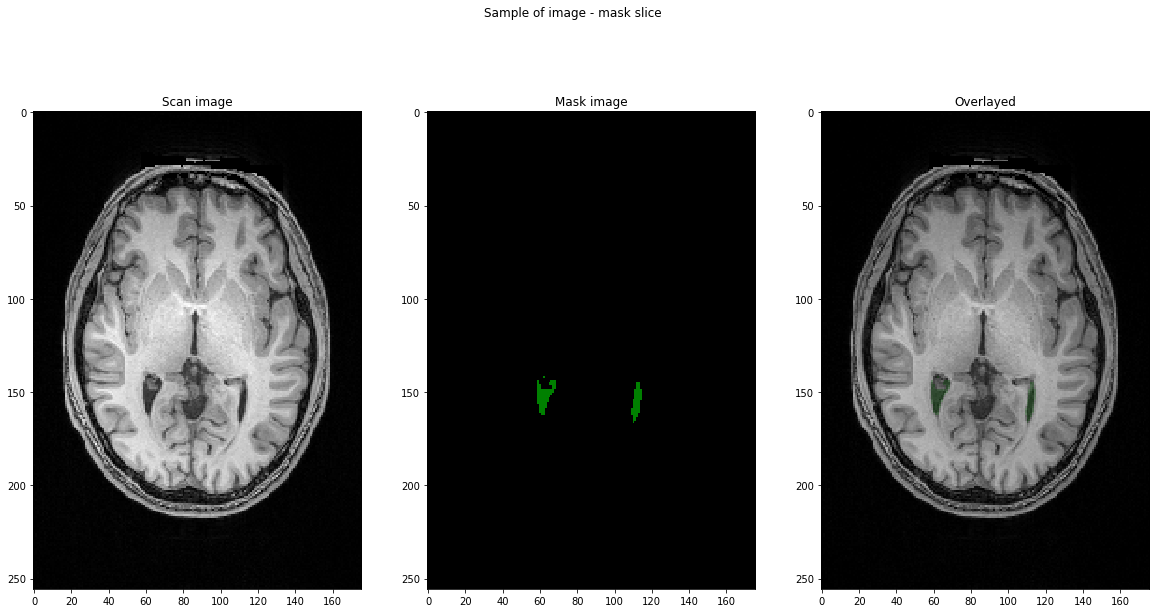

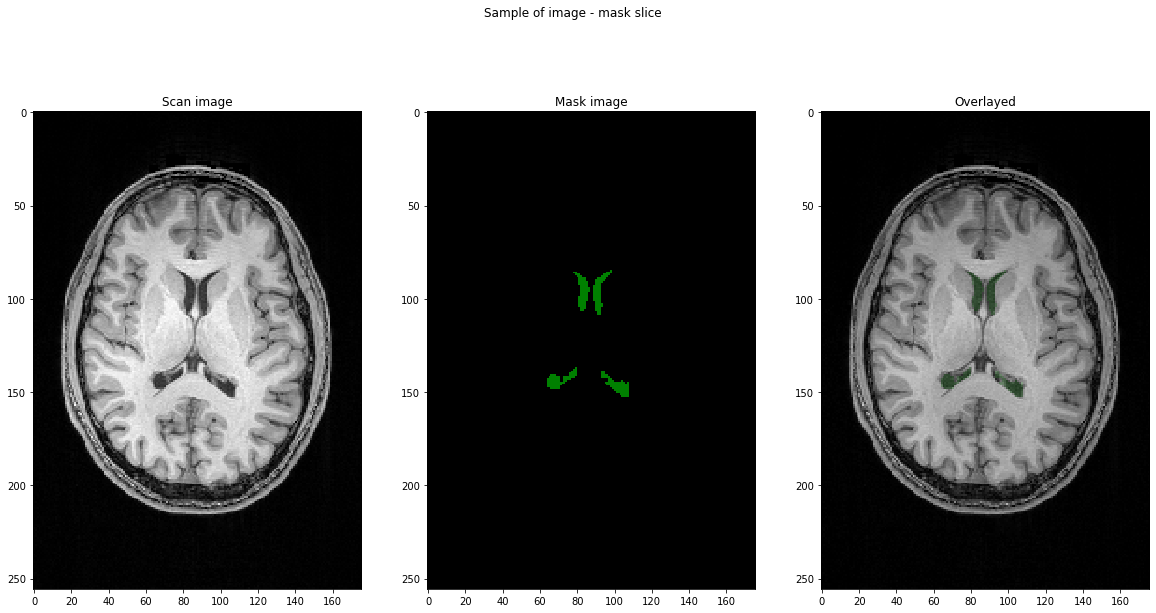

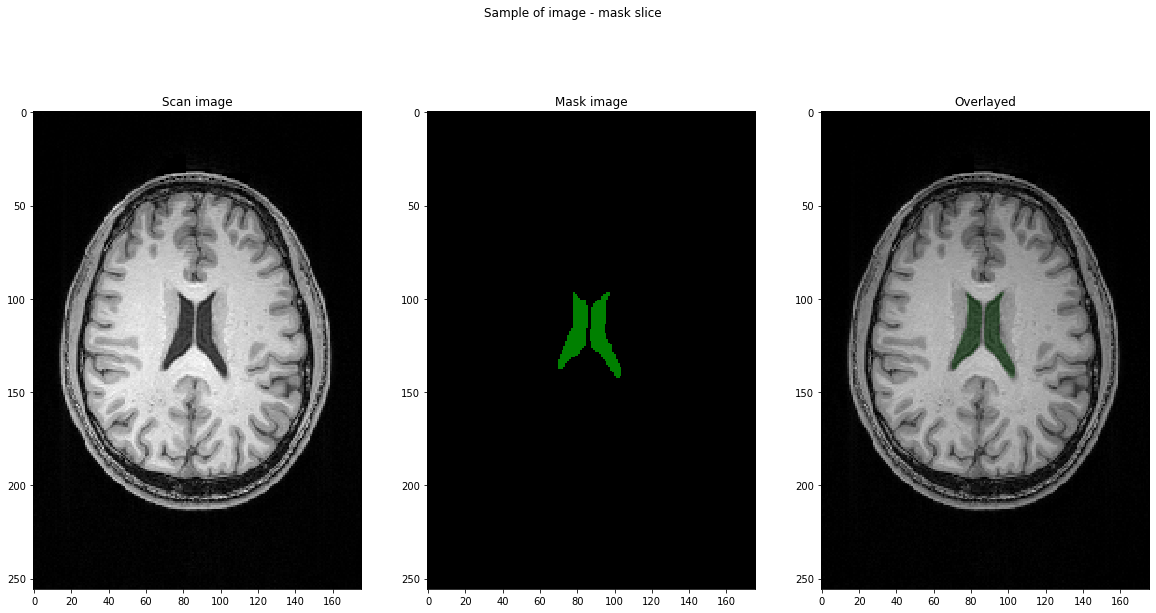

In [13]:
create_training_dataset(image_data, mask_data, labels, '', axis=2)